In [2]:
import numpy as np
import pandas as pd
import igraph as ig
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, matthews_corrcoef, roc_curve, auc
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression


graph = r'C:\Users\George\Desktop\ISEF-2023\Network construction\PPI_homo_graph_features_loaded.graphml'
embedding = r'C:\Users\George\Desktop\ISEF-2023\Model\test\ImGAGN\Embedding.csv'
# Create an igraph object
PPI_graph = ig.Graph.Load(graph, format='graphml')

feature_keys = [
    "Indegree", "Outdegree", "Closeness", "Betweenness", "Pagerank", "Cluster_coefficients",
    "Nearest_Neighbor_Degree", "Similarity", "Subunit", "Transmembrane",
    "Catalytic_activity", "Interaction", "Tissue_Specificity", "Disease",
    "Sequence_conflict", "Modified_residue", "Function", "Binding_site",
    "Natural_variant", "Alternative_products", "Subcellular_location",
    "Active_site", "Disulfide_bond", "Mutagenesis", "PTM", "STP_involvement"
]

featu = np.array([PPI_graph.vs[key] for key in feature_keys]).T
featu = pd.DataFrame(featu)
embed = pd.read_csv(embedding)

idx_train = torch.load('idx_train.pt')
idx_test = torch.load('idx_test.pt')


embed_test = embed.iloc[idx_test, :]
featu_test = featu.iloc[idx_test, :]
protein_names_test = embed_test['protein_name'].to_numpy()
embed_label_test = embed_test['labels'].to_numpy()
embed_test.drop('protein_name', axis=1, inplace=True)
embed_test.drop('labels', axis=1, inplace=True)



protein = {}

for i in range(7391):
    protein[i] = (embed['protein_name'][i], embed['labels'][i])
    

idx_train_false = torch.tensor([x for x in range(7391) if x not in idx_test and embed['labels'][x] == 0])
idx_train_true = torch.tensor([x for x in range(7391) if x not in idx_test and embed['labels'][x] == 1])
idx_train = torch.tensor([x for x in range(7391) if x not in idx_test])
X_test =  np.concatenate((embed_test, featu_test), axis=1)

print(idx_train_false)

C:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\igraph\io\files.py:295: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:492
  return reader(f, *args, **kwds)
C:\Users\George\AppData\Local\Temp\ipykernel_10916\809945017.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embed_test.drop('protein_name', axis=1, inplace=True)
C:\Users\George\AppData\Local\Temp\ipykernel_10916\809945017.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embed_test.drop('labels', axis=1, inplace=True)


tensor([   1,    2,    3,  ..., 7386, 7387, 7388])


In [3]:
def draft_samples(data, num_drafts=50, draft_size=150):
    """
    Draft samples from the data with minimal overlap.

    Parameters:
    - data: The dataset to draft from.
    - num_drafts: The number of drafts to make.
    - draft_size: The number of elements in each draft.

    Returns:
    - A list of drafts, where each draft is a list of elements from the data.
    """
    np.random.seed(42)  # For reproducibility
    total_data = len(data)
    drafts = []

    # Ensure the entire dataset is covered by adjusting the draft size if necessary
    adjusted_draft_size = max(draft_size, total_data // num_drafts)

    # Shuffle data indices to randomize drafting
    indices = np.arange(total_data)
    np.random.shuffle(indices)

    # Split indices into approximately equal-sized chunks
    chunks = np.array_split(indices, num_drafts)

    for chunk in chunks:
        # If the chunk is smaller than the draft size, sample additional indices from the entire dataset
        if len(chunk) < adjusted_draft_size:
            extra_indices = np.random.choice(indices, size=adjusted_draft_size - len(chunk), replace=False)
            chunk = np.concatenate((chunk, extra_indices))
        draft = [int(data[i]) for i in chunk[:adjusted_draft_size]]
        drafts.append(draft)

    return drafts

drafted = draft_samples(idx_train_false)

In [4]:
def evaluate_model(y_test, predictions, proba):
    from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, matthews_corrcoef, roc_curve, auc
    import matplotlib.pyplot as plt

    accuracy = accuracy_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    auc_roc = roc_auc_score(y_test, proba)  # Assuming positive class probabilities are in the second column
    mcc = matthews_corrcoef(y_test, predictions)
    
    print(f"Accuracy: {accuracy}\nRecall: {recall}\nPrecision: {precision}\nAUC-ROC: {auc_roc}\nMCC: {mcc}")
    
    fpr, tpr, thresholds = roc_curve(y_test, proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_roc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleNN(nn.Module):
    def __init__(self, input_size, mid):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, mid)  # Input layer to hidden layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(mid, 1)           # Hidden layer to output layer
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [6]:
#data preparation

training_data = []

for draft in drafted:
    
    false_idx = torch.tensor(draft)
    true_idx = idx_train_true
    
    embed_false = embed.iloc[false_idx, :]
    embed_true = embed.iloc[true_idx, :]
    featu_false = featu.iloc[false_idx, :]
    featu_true = featu.iloc[true_idx, :]
    
    false_both = np.concatenate((featu_false, embed_false), axis=1)
    true_both = np.concatenate((featu_true, embed_true), axis=1)
    
    train_temp = np.concatenate((true_both, false_both), axis = 0)
    
    np.random.shuffle(train_temp)
    
    train_temp_label = train_temp[:, -2]
    train_temp = train_temp[:, :-2]
    
    train_temp_label = train_temp_label.astype(int)
    train_temp = train_temp.astype(int)
    
    training_data.append((train_temp_label, train_temp))  

In [7]:
#training

models_lgb = []
models_rf = []
models_xgb = []
X_test =  np.concatenate((featu_test, embed_test), axis=1)
y_test = embed_label_test
i = 1

for data in training_data:
    
    X_train = data[1]
    y_train = data[0]
    
    #smote = SMOTE(random_state=42)
    #X_train, y_train = smote.fit_resample(X_train, y_train)
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    xgb_model.fit(X_train, y_train)
    
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    
    lgbm = LGBMClassifier(verbose=-1)
    lgbm.fit(X_train, y_train)
    
    
    models_xgb.append(xgb_model)
    models_rf.append(rf)
    models_lgb.append(lgbm)
    print(f"batch {i}")

    i += 1


batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
batch 49
batch 50


ALL
Accuracy: 0.9526600541027953
Recall: 0.44
Precision: 0.10784313725490197
AUC-ROC: 0.902453260373917
MCC: 0.20084658388309654


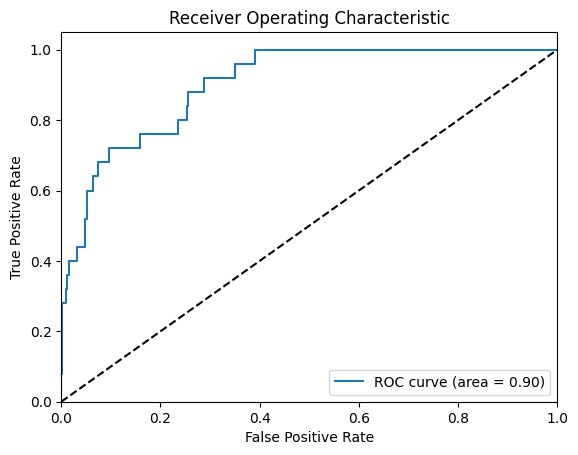


LGB
Accuracy: 0.957619477006312
Recall: 0.4
Precision: 0.11235955056179775
AUC-ROC: 0.9036388508891928
MCC: 0.19578507324940503


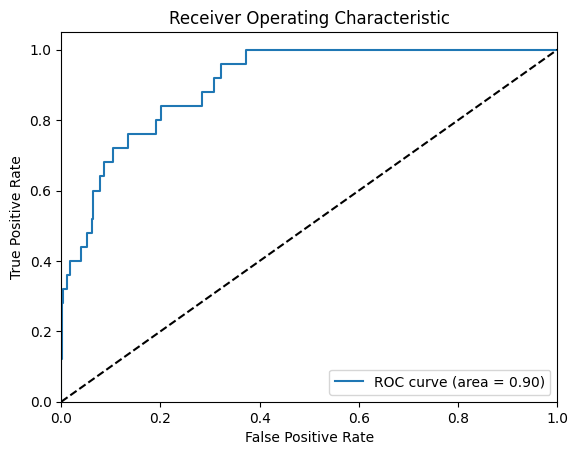


RF
Accuracy: 0.9531109107303878
Recall: 0.48
Precision: 0.11650485436893204
AUC-ROC: 0.895266757865937
MCC: 0.21998314672133096


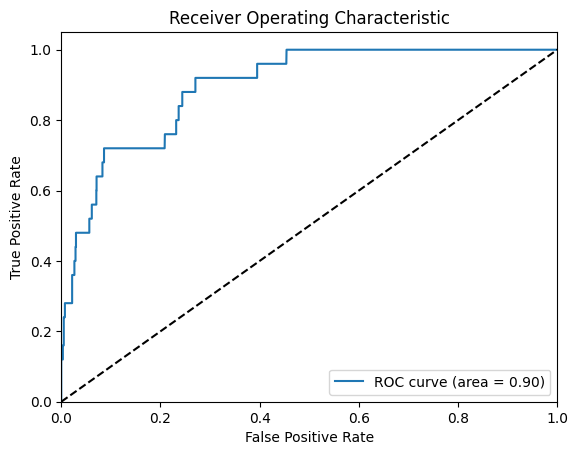


XGB
Accuracy: 0.9427412082957619
Recall: 0.56
Precision: 0.1076923076923077
AUC-ROC: 0.8956497948016416
MCC: 0.22790287062264888


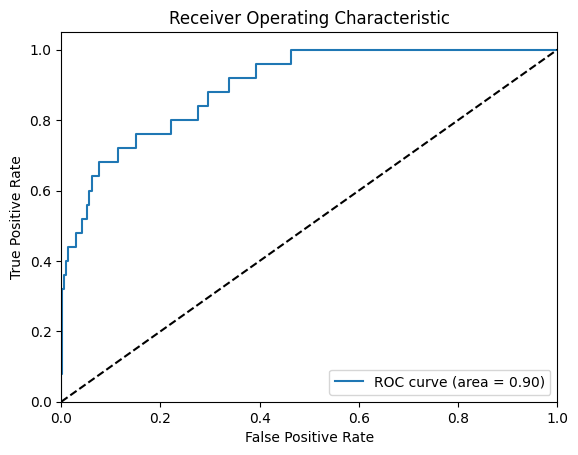

In [8]:
probs_xgb = []
probs_lgb = []
probs_rf = []
probs_all = []

for i in range(50):
    
    lgbmodel = models_lgb[i]
    rfmodel = models_rf[i]
    xgbmodel = models_xgb[i]
    
    xgb_predictions = xgbmodel.predict(X_test)
    xgb_proba = xgbmodel.predict_proba(X_test)
    probs_xgb.append(xgb_proba[:, 1])
    
    rf_predictions = rfmodel.predict(X_test)
    rf_proba = rfmodel.predict_proba(X_test)
    probs_rf.append(rf_proba[:, 1])
    
    lgb_predictions = lgbmodel.predict(X_test)
    lgb_proba = lgbmodel.predict_proba(X_test)
    probs_lgb.append(lgb_proba[:, 1])
    
    probs_all.append(lgb_proba[:, 1])
    probs_all.append(xgb_proba[:, 1])
    probs_all.append(rf_proba[:, 1])
    

print('ALL') 
proba_all_means = np.mean(probs_all, axis=0)
prediction_all_means = np.around(proba_all_means)
evaluate_model(y_test, prediction_all_means, proba_all_means)
print()


print('LGB') 
proba_lgb_means = np.mean(probs_lgb, axis=0)
prediction_lgb_means = np.around(proba_lgb_means)
evaluate_model(y_test, prediction_lgb_means, proba_lgb_means)
print()


print('RF') 
proba_rf_means = np.mean(probs_rf, axis=0)
prediction_rf_means = np.around(proba_rf_means)
evaluate_model(y_test, prediction_rf_means, proba_rf_means)
print()


print('XGB') 
proba_xgb_means = np.mean(probs_xgb, axis=0)
prediction_xgb_means = np.around(proba_xgb_means)
evaluate_model(y_test, prediction_xgb_means, proba_xgb_means)
print()

In [9]:
#hyper parameter test function
import optuna
from optuna import Trial

def xgb_hyper_tune(trial):
    
    
    param = {
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'eta': trial.suggest_float('eta', 0.01, 1),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'tree_method': 'auto',
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 100),
        'max_leaves': trial.suggest_int('max_leaves', 0, 255)
    }
    
    
    
    models_xgb = []
    probs_xgb = []
    X_test =  np.concatenate((featu_test, embed_test), axis=1)
    y_test = embed_label_test
    
    for data in training_data:
    
        X_train = data[1]
        y_train = data[0]

        #smote = SMOTE(random_state=42)
        #X_train, y_train = smote.fit_resample(X_train, y_train)
        xgb_model = xgb.XGBClassifier(**param, use_label_encoder=False, eval_metric='logloss')
        xgb_model.fit(X_train, y_train)
        
        models_xgb.append(xgb_model)
        
    for i in range(50):
    
        xgbmodel = models_xgb[i]

        xgb_predictions = xgbmodel.predict(X_test)
        xgb_proba = xgbmodel.predict_proba(X_test)
        probs_xgb.append(xgb_proba[:, 1])
        
    proba_xgb_means = np.mean(probs_xgb, axis=0)
    auc_roc = roc_auc_score(y_test, proba_xgb_means)
    
    return auc_roc


In [19]:
import warnings

# Suppress all user warnings
warnings.filterwarnings("ignore", category=UserWarning)

study1 = optuna.create_study(direction='maximize')
study1.optimize(xgb_hyper_tune, n_trials=100) # Adjust n_trials to your needs  

[I 2024-02-24 07:34:29,255] A new study created in memory with name: no-name-2eb9a170-bb1a-4f2c-9022-303104d8714f
[I 2024-02-24 07:35:18,431] Trial 0 finished with value: 0.8782124943000457 and parameters: {'booster': 'dart', 'eta': 0.7645977461276035, 'gamma': 0.7099544130765562, 'max_depth': 6, 'min_child_weight': 5, 'max_delta_step': 2, 'subsample': 0.7951086418372231, 'colsample_bytree': 0.8786145457442398, 'colsample_bylevel': 0.9761144843985949, 'colsample_bynode': 0.8111297740439831, 'lambda': 0.009775526037294043, 'alpha': 9.779606132938113, 'scale_pos_weight': 64.26192291873464, 'max_leaves': 196}. Best is trial 0 with value: 0.8782124943000457.
[I 2024-02-24 07:36:07,529] Trial 1 finished with value: 0.8676516187870497 and parameters: {'booster': 'dart', 'eta': 0.806936975716162, 'gamma': 1.3779613985646773, 'max_depth': 6, 'min_child_weight': 4, 'max_delta_step': 9, 'subsample': 0.8393728821292866, 'colsample_bytree': 0.659810171916599, 'colsample_bylevel': 0.664894899153461

In [15]:
print(study1.trials)
optuna.visualization.plot_slice(study1)

#first time, 100 trials
#alpha, 0.1 - 10
#colsample_bylevel, 0.8 - 0.9
#colsampl_bynode, 0.6 - 0.75
#colsample_bytree, 0.5 - 0.7
#eta, 0.5, 0.7
#gamma, 0, 2
#lambda, 0.1, 2
#max_leaves, 0, 100
#scale_pos_weight, 5, 40
#subsample, 0.8, 0.9

params_lgb = {'boosting_type': 'dart', 'num_leaves': 146, 'max_depth': 33, 'learning_rate': 0.17903884590309674, 'n_estimators': 962, 'min_split_gain': 0.8147283428238035, 'min_child_weight': 0.6420923053558756, 'min_child_samples': 8, 'subsample': 0.8820150555477321, 'subsample_freq': 1, 'colsample_bytree': 0.4003063938218889, 'reg_alpha': 0.019202893763041753, 'reg_lambda': 3.131238928994375, 'scale_pos_weight': 79.31554135858411, 'cat_smooth': 50, 'feature_fraction': 0.7251299028866509, 'bagging_fraction': 0.8738735746381723, 'bagging_freq': 4, 'max_bin': 221, 'extra_trees': False, 'path_smooth': 0.18825246051702954, 'dart_mode': False, 'drop_rate': 0.3585193339497376}
params_xgb = {'booster': 'dart', 'eta': 0.815413769847561, 'gamma': 2.5508270472496886, 'max_depth': 4, 'min_child_weight': 0, 'max_delta_step': 7, 'subsample': 0.6259613870651987, 'colsample_bytree': 0.5851007174007999, 'colsample_bylevel': 0.7871435104494688, 'colsample_bynode': 0.5321538730514848, 'lambda': 0.5565024132239251, 'alpha': 0.018954922224368297, 'scale_pos_weight': 1.003405679458028, 'max_leaves': 181}

[FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.8945371637026903], datetime_start=datetime.datetime(2024, 2, 23, 23, 6, 50, 974705), datetime_complete=datetime.datetime(2024, 2, 23, 23, 7, 32, 200018), params={'booster': 'dart', 'eta': 0.16071615686245183, 'gamma': 2.65060477053249, 'max_depth': 7, 'min_child_weight': 5, 'max_delta_step': 2, 'subsample': 0.5827636808714756, 'colsample_bytree': 0.7842527714218066, 'colsample_bylevel': 0.9575037328400278, 'colsample_bynode': 0.8216755344707819, 'lambda': 0.7679911384770417, 'alpha': 0.04140662696580462, 'scale_pos_weight': 28.010455070768582, 'max_leaves': 87}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'booster': CategoricalDistribution(choices=('gbtree', 'dart')), 'eta': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0.0, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_weight': IntDistributio

In [34]:
def lgb_hyper_tune(trial):
    
    
    param = {
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'eta': trial.suggest_float('eta', 0.01, 1),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'tree_method': 'auto',
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 100),
        'max_leaves': trial.suggest_int('max_leaves', 0, 255)
    }
    
    
    
    models_lgb = []
    probs_lgb = []
    X_test =  np.concatenate((featu_test, embed_test), axis=1)
    y_test = embed_label_test
    
    for data in training_data:
    
        X_train = data[1]
        y_train = data[0]

        #smote = SMOTE(random_state=42)
        #X_train, y_train = smote.fit_resample(X_train, y_train)
        lgb_model = LGBMClassifier(**param, verbose=-1, eval_metric='logloss')
        lgb_model.fit(X_train, y_train)
        
        models_lgb.append(lgb_model)
        
    for i in range(50):
    
        lgbmodel = models_lgb[i]

        lgb_predictions = lgbmodel.predict(X_test)
        lgb_proba = lgbmodel.predict_proba(X_test)
        probs_lgb.append(lgb_proba[:, 1])
        
    proba_lgb_means = np.mean(probs_lgb, axis=0)
    auc_roc = roc_auc_score(y_test, proba_lgb_means)
    
    return auc_roc

In [35]:
import warnings

# Suppress all user warnings
warnings.filterwarnings("ignore", category=UserWarning)

study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(lgb_hyper_tune, n_trials=200) # Adjust n_trials to your needs  

[I 2024-02-24 15:09:05,112] A new study created in memory with name: no-name-15d864b2-3cf2-40bd-ba69-ca1a7a022849
[I 2024-02-24 15:09:07,608] Trial 0 finished with value: 0.8832831737346102 and parameters: {'booster': 'dart', 'eta': 0.3328965884762373, 'gamma': 0.2924579489302742, 'max_depth': 9, 'min_child_weight': 0, 'max_delta_step': 10, 'subsample': 0.8527077014861588, 'colsample_bytree': 0.5190516425873973, 'colsample_bylevel': 0.9818866653304079, 'colsample_bynode': 0.7378221646903089, 'lambda': 0.0030705410058422594, 'alpha': 0.0036911061889726947, 'scale_pos_weight': 52.57549099280269, 'max_leaves': 212}. Best is trial 0 with value: 0.8832831737346102.
[I 2024-02-24 15:09:09,295] Trial 1 finished with value: 0.8693844049247605 and parameters: {'booster': 'gbtree', 'eta': 0.868257915452356, 'gamma': 1.8745725621285452, 'max_depth': 5, 'min_child_weight': 8, 'max_delta_step': 8, 'subsample': 0.9932856734535478, 'colsample_bytree': 0.8736925988145269, 'colsample_bylevel': 0.629674

In [33]:
print(study_lgb.trials)
optuna.visualization.plot_slice(study_lgb)
#best_trial = study_lgb.best_trial
#print(best_trial)

[FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.5], datetime_start=datetime.datetime(2024, 2, 24, 13, 7, 56, 748899), datetime_complete=datetime.datetime(2024, 2, 24, 13, 7, 58, 415275), params={'boosting_type': 'dart', 'num_leaves': 101, 'max_depth': 60, 'learning_rate': 0.2613492381197124, 'n_estimators': 484, 'min_split_gain': 0.7286781072386462, 'min_child_weight': 0.035569999201352925, 'min_child_samples': 88, 'subsample': 0.873899778160312, 'subsample_freq': 7, 'colsample_bytree': 0.719557180763425, 'reg_alpha': 1.7713357675941865, 'reg_lambda': 1.282536173050628, 'scale_pos_weight': 57.55411522569685, 'cat_smooth': 33, 'feature_fraction': 0.9304625705786039, 'bagging_fraction': 0.5524292845285829, 'bagging_freq': 3, 'max_bin': 204, 'extra_trees': False, 'path_smooth': 0.03591891792354329, 'dart_mode': False, 'drop_rate': 0.16417600154941092}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'boosting_type': CategoricalDistribution(choices=('gbdt

batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
batch 49
batch 50
ALL
Accuracy: 0.9413886384129847
Recall: 0.56
Precision: 0.10526315789473684
AUC-ROC: 0.9233926128590971
MCC: 0.22487165287708732


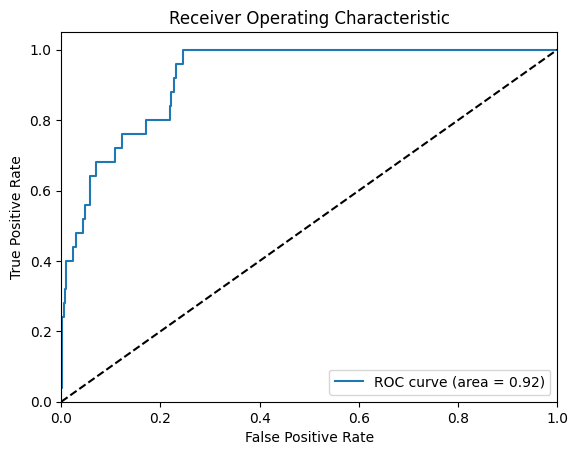


LGB
Accuracy: 0.9319206492335438
Recall: 0.64
Precision: 0.10126582278481013
AUC-ROC: 0.9163337893296855
MCC: 0.2360927631283495


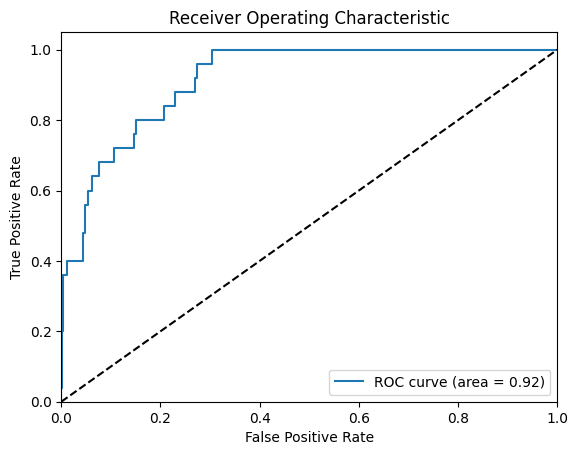


XGB
Accuracy: 0.9481514878268711
Recall: 0.52
Precision: 0.11206896551724138
AUC-ROC: 0.9274965800273598
MCC: 0.22430287277432065


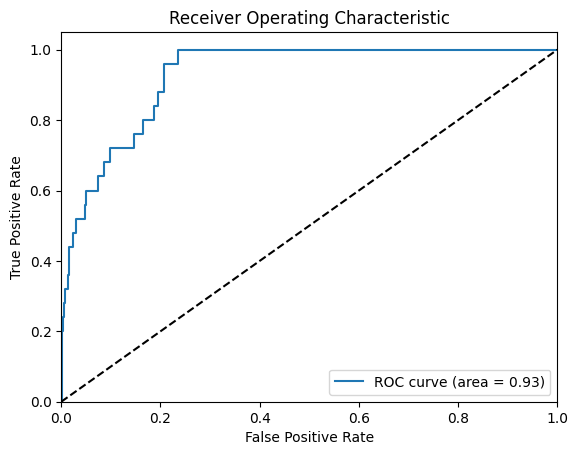

In [32]:

params_lgb = {'boosting_type': 'dart', 'num_leaves': 146, 'max_depth': 33, 'learning_rate': 0.17903884590309674, 'n_estimators': 962, 'min_split_gain': 0.8147283428238035, 'min_child_weight': 0.6420923053558756, 'min_child_samples': 8, 'subsample': 0.8820150555477321, 'subsample_freq': 1, 'colsample_bytree': 0.4003063938218889, 'reg_alpha': 0.019202893763041753, 'reg_lambda': 3.131238928994375, 'scale_pos_weight': 79.31554135858411, 'cat_smooth': 50, 'feature_fraction': 0.7251299028866509, 'bagging_fraction': 0.8738735746381723, 'bagging_freq': 4, 'max_bin': 221, 'extra_trees': False, 'path_smooth': 0.18825246051702954, 'dart_mode': False, 'drop_rate': 0.3585193339497376}
params_xgb = {'booster': 'dart', 'eta': 0.815413769847561, 'gamma': 2.5508270472496886, 'max_depth': 4, 'min_child_weight': 0, 'max_delta_step': 7, 'subsample': 0.6259613870651987, 'colsample_bytree': 0.5851007174007999, 'colsample_bylevel': 0.7871435104494688, 'colsample_bynode': 0.5321538730514848, 'lambda': 0.5565024132239251, 'alpha': 0.018954922224368297, 'scale_pos_weight': 1.003405679458028, 'max_leaves': 181}


models_lgb = []
models_xgb = []
X_test =  np.concatenate((featu_test, embed_test), axis=1)
y_test = embed_label_test
i = 1

for data in training_data:
    
    X_train = data[1]
    y_train = data[0]
    
    #smote = SMOTE(random_state=42)
    #X_train, y_train = smote.fit_resample(X_train, y_train)
    xgb_model = xgb.XGBClassifier(**params_xgb, use_label_encoder=False, eval_metric='logloss')
    xgb_model.fit(X_train, y_train)
    
    
    lgbm =  LGBMClassifier(**params_lgb, verbose=-1, eval_metric='logloss')
    lgbm.fit(X_train, y_train)
    
    
    models_xgb.append(xgb_model)
    models_lgb.append(lgbm)
    print(f"batch {i}")

    i += 1




probs_xgb = []
probs_lgb = []
probs_all = []

for i in range(50):
    
    lgbmodel = models_lgb[i]
    rfmodel = models_rf[i]
    xgbmodel = models_xgb[i]
    
    xgb_predictions = xgbmodel.predict(X_test)
    xgb_proba = xgbmodel.predict_proba(X_test)
    probs_xgb.append(xgb_proba[:, 1])
    
    lgb_predictions = lgbmodel.predict(X_test)
    lgb_proba = lgbmodel.predict_proba(X_test)
    probs_lgb.append(lgb_proba[:, 1])
    
    probs_all.append(lgb_proba[:, 1])
    probs_all.append(xgb_proba[:, 1])

    

print('ALL') 
proba_all_means = np.mean(probs_all, axis=0)
prediction_all_means = np.around(proba_all_means)
evaluate_model(y_test, prediction_all_means, proba_all_means)
print()


print('LGB') 
proba_lgb_means = np.mean(probs_lgb, axis=0)
prediction_lgb_means = np.around(proba_lgb_means)
evaluate_model(y_test, prediction_lgb_means, proba_lgb_means)
print()


print('XGB') 
proba_xgb_means = np.mean(probs_xgb, axis=0)
prediction_xgb_means = np.around(proba_xgb_means)
evaluate_model(y_test, prediction_xgb_means, proba_xgb_means)
print()



In [72]:
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, f1_score

threshold = 0.805
predictions = [1 if prob > threshold else 0 for prob in proba_all_means]

conf_matrix = confusion_matrix(y_test, predictions)
print(conf_matrix)

print('\n')

recall = recall_score(y_test, predictions, zero_division=0)
f1_score_ = f1_score(y_test, predictions)
precision = precision_score(y_test, predictions, zero_division=0)
report = classification_report(y_test, predictions, output_dict=True)
matthews_coeff = matthews_corrcoef(y_test, predictions)

results = {
    'Recall': recall,
    'Precision': precision,
    'F1 Score': f1_score_,
    'Matthews Correlation Coefficient': matthews_coeff,

}

for metric_name, metric_value in results.items():
    print(f"{metric_name}: {metric_value}")
    print("\n")

[[2160   33]
 [  15   10]]


Recall: 0.4


Precision: 0.23255813953488372


F1 Score: 0.29411764705882354


Matthews Correlation Coefficient: 0.29473531637173966




In [31]:
probs_final_result = []
probs_final_result_xgb = []
names_analyze = embed['protein_name'].to_numpy()
labels_analyze = embed['labels'].to_numpy()
analyze_data = np.concatenate((featu, embed.iloc[:7392, :-2]), axis=1)

for i in range(50):
    
    lgbmodel = models_lgb[i]
    rfmodel = models_rf[i]
    xgbmodel = models_xgb[i]
    
    xgb_predictions = xgbmodel.predict(analyze_data)
    xgb_proba = xgbmodel.predict_proba(analyze_data)
    probs_final_result_xgb.append(xgb_proba[:, 1])
    
    lgb_predictions = lgbmodel.predict(analyze_data)
    lgb_proba = lgbmodel.predict_proba(analyze_data)
    
    probs_final_result.append(lgb_proba[:, 1])
    probs_final_result.append(xgb_proba[:, 1])


In [32]:
proba_all_means_analyze = np.mean(probs_final_result_xgb, axis=0)
print(proba_all_means_analyze.shape)
print(names_analyze.shape)
output = pd.DataFrame({
    "Name": names_analyze[:7392],
    "Probability": proba_all_means_analyze
})

output = output.sort_values(by="Probability", ascending=False)

csv_file_path = 'prediction_all_xgb+lgb_finetuned.csv'
output.to_csv(csv_file_path, index=False)

my_list = ['P18507', 'P23416', 'P21918', 'P31513', 'P28472', 'P35367', 'O00591', 'P19838', 'P19634', 'P08908', 'P47869', 'Q00653', 'P18505', 'P31645', 'Q12809', 'P02768', 'P98066', 'P35348', 'P10635', 'P05067', 'Q12879', 'P08173', 'O15399', 'P14867', 'P20813', 'Q8N1C3', 'P47870', 'P08913', 'P06276', 'P21728', 'P14416', 'P35368', 'P24462', 'P46098', 'P31644', 'P20309', 'P11712', 'O14764', 'P08172', 'P20815', 'O60391', 'Q13224', 'P50406', 'P08588', 'P28566', 'Q14957', 'P22303', 'P35462', 'Q96FL8', 'Q9UNQ0', 'P25100', 'P28222', 'Q9UN88', 'P08684', 'P33261', 'P02763', 'P11229', 'P07550', 'P28223', 'O75311', 'Q9HB55', 'P21917', 'P48167', 'Q9H015', 'P22310', 'P28221', 'Q16445', 'P28335', 'P13945', 'P23415', 'P78334', 'P36544', 'P05177', 'P34903', 'P30939', 'Q99928', 'Q05586', 'P08183', 'P48169', 'Q8TCU5', 'P11509', 'P05181', 'P18089']

output = output[~output['Name'].isin(my_list)]
print(output.all)

csv_file_path = 'prediction_unknown_xgb+lgb_finetuned.csv'
output.to_csv(csv_file_path, index=False)

(7392,)
(12450,)
<bound method NDFrame._add_numeric_operations.<locals>.all of         Name  Probability
3902  P49286     0.977555
3736  Q15825     0.976407
2329  A8MPY1     0.975025
5395  P43119     0.974215
7332  Q04844     0.970939
...      ...          ...
4283  Q8NC69     0.000132
1853  Q96EK5     0.000132
6895  P20226     0.000124
3857  O14879     0.000124
3019  O43924     0.000108

[7309 rows x 2 columns]>
